# Lab Exercise: The Radial Distribution Function for Flying Discs

In this Notebook we analyse movies taken from a 2D particle simulator used for educational purposes. In this device, small magnetic and repulsive discs move on a flat surface due to air flowing from the sides as well as from underneath to reduce friction (see figure below). The particles are confined by repulsive, magnetic bars, located on the four sides of the quadratic surface.

![alternate text](figs/experiment.png)

### Tips for Jupyter Notebooks
- Double click on a cell to edit it.
- Execute code in a cell by pressing `shift+return`.
- For getting help on a function, place the cursor inside the `()` brackets and press `shift+tab-tab`.
- More on text formatting, equations etc.
[here](http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb).

## Part I: Structure

In the first part we explore the radial distribution function (RDF), $g(r)$.

**Flow of program**:
0. split video into individual images (requires `ffmpeg`)
0. find particle positions and save to trajectory file (`.h5` format)
0. calculate distance histogram
0. calculate radial distribution function

More here info about the particle tracker
[here](http://soft-matter.github.io/trackpy/dev/index.html).


In [1]:
# load modules required for the analysis
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
from pandas import DataFrame, Series
import os, pims, scipy, trackpy as tp
from scipy.spatial import distance
from IPython.display import HTML
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})

def video(file):
    """ Show given video file """
    video_tag = '<video controls width="400" alt="video" src="{file}">'.format(file=file)
    return HTML(video_tag)

### Input Data
The following videos of particle simulations were recorded using a smart phone and these will be the basis of the following analysis. Select a video from the list via it's index.

In [2]:
movies = [
    {'file': 'movies/N20-light.mp4', 'percentile': 60, 'diameter': 53},
    {'file': 'movies/N40-light.mp4', 'percentile': 60, 'diameter': 53},
    {'file': 'movies/N55-light.mp4', 'percentile': 60, 'diameter': 53}
] # more movies can be added as needed...

movie = movies[1]  # select movie file here by index, starting from 0
moviefile=movie['file']
video(moviefile)

### Split movie into individual files

Here we use the command line tool `ffmpeg` to split the movie into individual images as these are easier for the `trackpy` module to handle.

In [3]:
imgdir=os.path.splitext(moviefile)[0]
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    !ffmpeg -i $moviefile -f image2 -vcodec mjpeg $imgdir/img-%03d.jpg -v 0

### Locate particle positions using image recognition 

Before analysing all frames found in the 10-15 sec movie, let's check if the (slow) feature extraction
works for a _single_ frame.

read 498 frames.
             x           y           mass       size       ecc      signal  \
35  308.253041  539.512792   90817.405327  13.932973  0.059877   94.873236   
36  399.132417  549.505522  127509.629417  15.471254  0.034491  101.296945   
37  231.113703  553.446636   84721.305771  14.024142  0.069153   85.978870   
38  145.572435  561.046082  106435.417700  15.383259  0.018180   93.884973   
39  487.205627  560.942103  112118.917505  15.741173  0.028750   97.343893   

    raw_mass        ep  frame  
35    317517  0.060766      0  
36    371207  0.046346      0  
37    325852  0.057966      0  
38    375968  0.045391      0  
39    389501  0.042879      0  


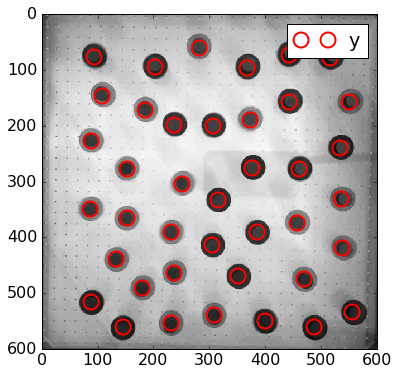

In [4]:
frames = pims.ImageSequence(imgdir+'/img*.jpg', as_grey=True) # load all frames
print('read',len(frames),'frames.')
f = tp.locate(frames[0], diameter=movie['diameter'], invert=True, percentile=movie['percentile'])
print(f.tail())

# this is how we may separate light and heavy particles
heavy = f[f['mass']>50000] # heavy particles
light = f[f['mass']<50000] # light particles

tp.annotate(f, frames[0])

### Extract particle positions from all frames

Assuming that the recognition settings are OK, let's loop over all frames, extract features, and save to a `.h5` trajectory file.
This process is done *only* if the trajectory file, `trjfile`, does not exist,

_Warning: this is a slow process!_

In [5]:
trjfile=os.path.splitext(moviefile)[0]+'.h5'
if os.path.isfile(trjfile):
    print('opening existing trajectory file', trjfile)
else:
    with tp.PandasHDFStore(trjfile) as s:
        cnt=0
        for image in frames:
            cnt=cnt+1
            print( 'frame %d/%d.' % (cnt, len(frames)), end=' ')
            features = tp.locate(
                image, diameter=movie['diameter'], percentile=movie['percentile'], invert=True)
            print('number of particles =',len(features))
            s.put(features[['x','y','mass','frame']])

opening existing trajectory file movies/N40-light.h5


### Read trajectory file and calculate distances between all points

In this section we calculate all distances between all particles for each frame. These are then binned into a histogram to give the probability of observing a particular separation.
At the same time we sample the distribution for _ideal_ particles by simply generating random positions and perform the same analysis as for the "real" particles.

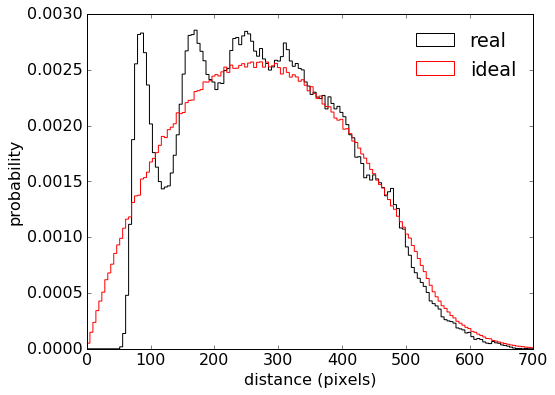

In [6]:
dist  = np.ndarray(shape=(0,0))  # movie distribution
udist = np.ndarray(shape=(0,0))  # uniform distribution

with tp.PandasHDFStore(trjfile) as s:
    # measure all distances between discs
    for frame in s:
        dist = np.append( dist, distance.pdist( frame[['x','y']] ))

    data = s.dump() # keep full trajectory in `data`
    
    # find box corners
    xmin,xmax = min(data.x), max(data.x)
    ymin,ymax = min(data.y), max(data.y)
    
    # measure distances for uniform, random distribution (no correlations)
    # (number of points/particles is unimportant.)
    x     = np.random.randint(xmin, xmax+1, size=4000)
    y     = np.random.randint(ymin, ymax+1, size=4000)
    p     = np.array([x, y]).T
    udist = np.append( udist, distance.pdist(p) )
        
    hist  = plt.hist(dist,  bins=150, normed=True, range=[0,700], histtype='step', color='black', label='real')
    uhist = plt.hist(udist, bins=150, normed=True, range=[0,700], histtype='step', color='red', label='ideal')

    plt.legend(loc=0,frameon=False)
    plt.xlabel('distance (pixels)')
    plt.ylabel('probability')

### Radial Distribution Function, $g(r)$

We have now calculated the distance distribution, `hist`, from the simulated particles from the movie, as well as for a uniform distribution of $N$ particles, `uhist`. The radial distribution function is simply the ratio between the two.
This means that if the particles were behaving ideally (which they don't), $g(r)$ would be unity for all separations, $r$. After plotting, the final rdf is saved to disk.

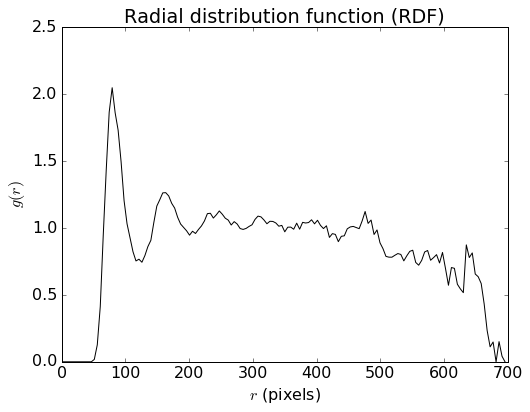

In [7]:
r = hist[1][:len(hist[0])]
g = hist[0] / uhist[0]
plt.plot( r, g, 'k-')
plt.xlabel('$r$ (pixels)')
plt.ylabel('$g(r)$')
plt.title('Radial distribution function (RDF)')

rdffile=os.path.splitext(moviefile)[0]+'.rdf.dat'
np.savetxt(rdffile, np.array([r,g]).T, header='rdf from '+moviefile)

### Plot all rdf's found on disk

(0, 4)

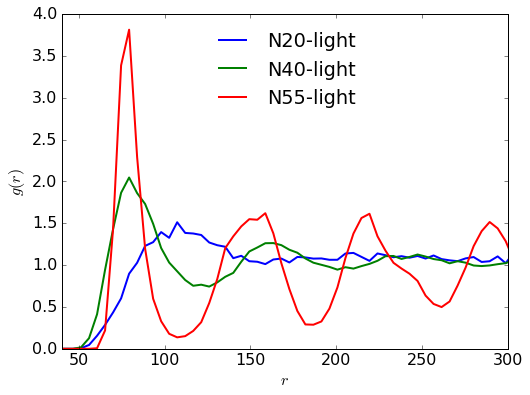

In [8]:
for d in movies:
    name = os.path.splitext(d['file'])[0]
    rdffile = name+'.rdf.dat'
    if os.path.isfile(rdffile):
      r, g = np.loadtxt(rdffile, unpack=True )
      plt.plot(r, g, '-', label=os.path.basename(name), lw=2)
plt.legend(loc=0,frameon=False)
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([40,300])
plt.ylim([0,4])

### Exercises, Part I
0. Why does $g(r)$ not go to unity at large separations?
0. What is the particle size and the system's volume fraction?
0. It seems as if there's a small maximum in $g(r)$ at short separations. Is this real and if so, how is this possible for repulsive particles?
0. Convert $g(r)$ to the potential of mean force and plot this.
0. Repeat the full analysis but for a more concentrated system. Discuss differences.

## Part II: Kinetics

This part is under construction. Todo:
- Compare velocity distribution w. Maxwell-Boltzmann
- Calculate diffusion coefficient

Frame 497: 40 trajectories present


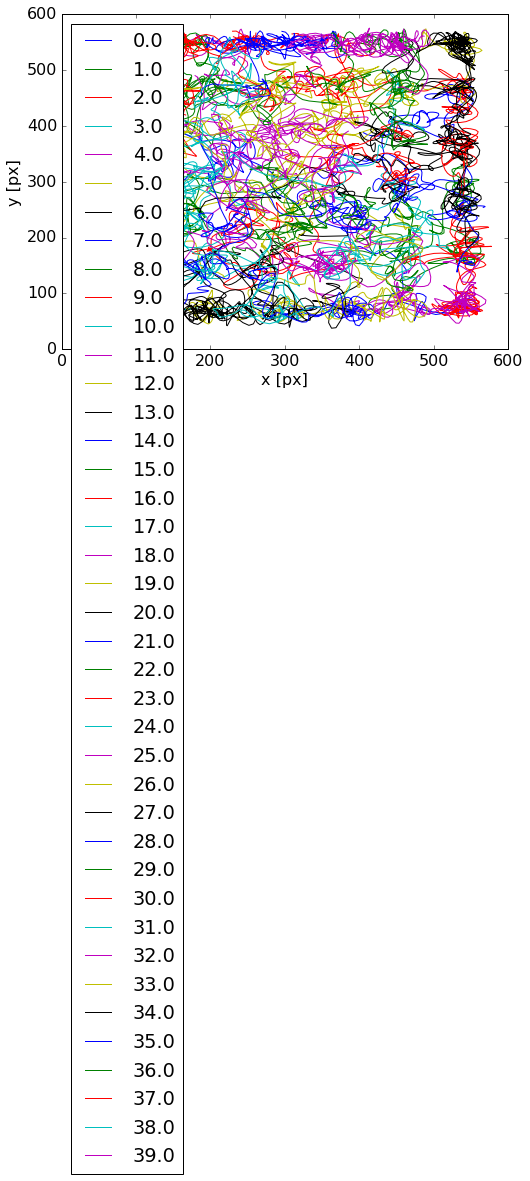

In [9]:
t = tp.link_df(data, search_range=20, memory=3)
tp.plot_traj(t)

In [10]:
em = tp.emsd(t, mpp=20./600., fps=24) # mpp=cm per pixel

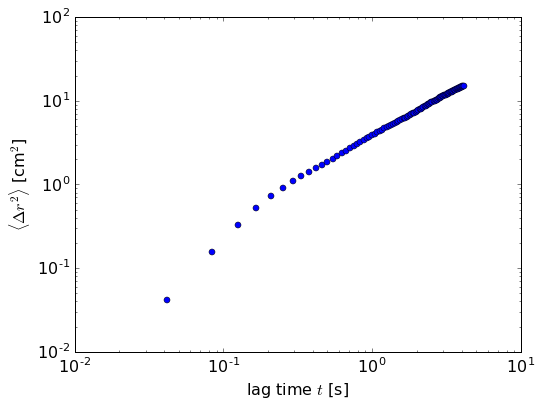

In [11]:
plt.plot(em.index, em, 'o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [cm$^2$]')
plt.xlabel('lag time $t$ [s]')

### Contact Information
Mikael Lund, Department of Theretical Chemistry  
Lund University, POB 124, SE-22100 Lund, Sweden  
http://www.teokem.lu.se